# 예측모델 : ARIMA, Seasonal ARIMA(SARIMA) 실습

ARIMA, SARIMA 모델을 실제 데이터에 적용

Box-Jenkins ARIMA Procedure

활용데이터 : 공공 데이터(airpassengers.csv), 실제 주가 예측

##모듈 불러오기

In [2]:
!pip install pandas_datareader
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 9.9 MB 42.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import os
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
#sns.set_style('white')
%matplotlib inline

import itertools

##데이터 불러오기

활용데이터 : 공공데이터(AirPassengers.csv)
*   1949년 ~ 1960년 매달 비행기 탑승객 수에 대한 시계열 데이터 (12달)
*   데이터 구조 [144 X 1]



In [4]:
Airdata = pd.read_csv("/content/sample_data/AirPassengers.csv")
Airdata

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [5]:
Airdata = Airdata.rename(columns={'date' : 'month', "value" : 'passengers'})
Airdata['month'] = pd.to_datetime(Airdata['month'])
Airdata

,month,passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [6]:
Airdata = Airdata.set_index('month')
Airdata

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


#Box-Jenkins ARIMA Procedure

*   1. Data Preprocessing (데이터 전처리)
*   2. Identity Model to be Tentatively Entertainted(모델 구축)
*   3. Estimate Parameters(탐색)
*   4. Diagnosis Check(확인)
*   5. use Model to Forecast



##1. Data Preprocessing

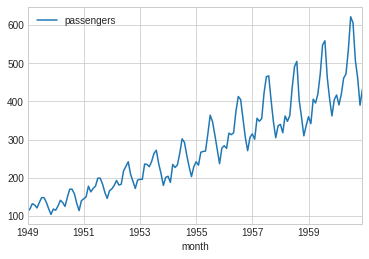

In [7]:
fig = Airdata.plot()

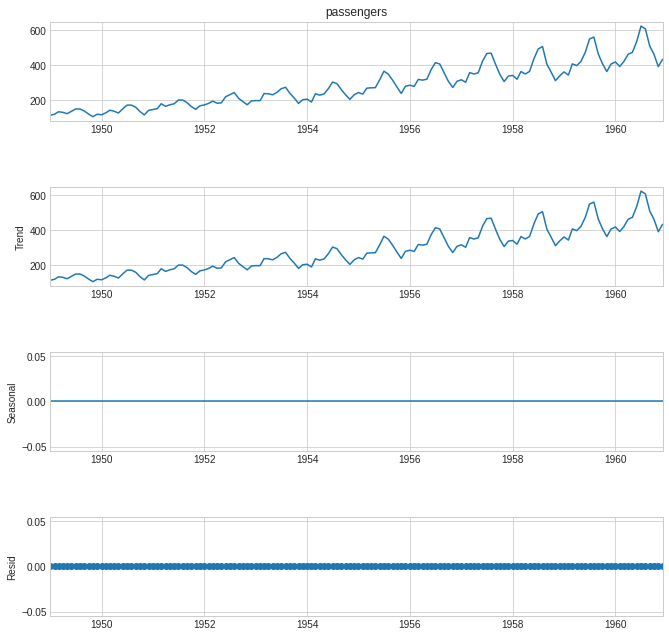

In [8]:
#Seasonal decomposition plot 는 seasonal decompostion using moving averages

#Observed : data observe
#Trend : the estimated trend component(추세)
#Seasonal : the estimated seasonal component(계절성)
#resid : the estimated residuals(잔차)
#https://yoongaemii.github.io/seasonal_decomposition/ (상세한 설명)
decompostion = sm.tsa.seasonal_decompose(Airdata['passengers'], model='additive', period =1)
fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

##2. Identity Model to be Tentatively Entertainted

모델 구축 : train 과 test를 분리(검증을 위한 분리) 시계열이라서 shuffle x

In [9]:
#train : test = 8:2
train_Airdata, test_Airdata = train_test_split(Airdata, test_size=0.2, shuffle=False)

In [10]:
train_Airdata

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-03-01,362
1958-04-01,348
1958-05-01,363


In [11]:
test_Airdata

,passengers
month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


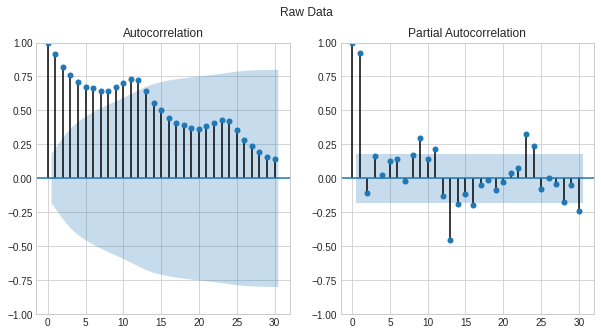

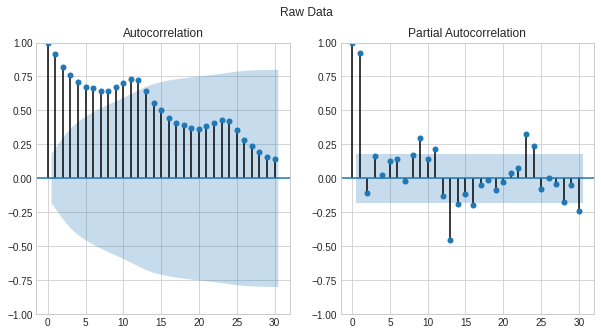

In [14]:
# autocorrelation function 과 partial autocorrelation function 상관관계
fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_Airdata.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_Airdata.values.squeeze(), lags=30, ax=ax[1])

차분(differencing) : 현 시점 데이터에서 d시점 이전 데이터를 뺀 것

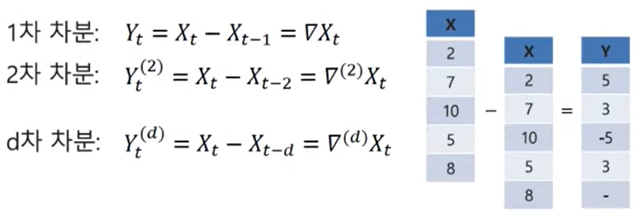

2    

7-2 = 5

10-7 = 3

5-10 = -5

8-5 = 3

O 8  Na

In [15]:
#Differencing
diff_train_Airdata = train_Airdata.copy()
diff_train_Airdata = diff_train_Airdata['passengers'].diff()
diff_train_Airdata = diff_train_Airdata.dropna() #마지막에 생긴 결측치(NA) 삭제
print("### Raw Data ###")
print(train_Airdata)
print("### Differenced Data ###")
print(diff_train_Airdata)

### Raw Data ###
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
### Differenced Data ###
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


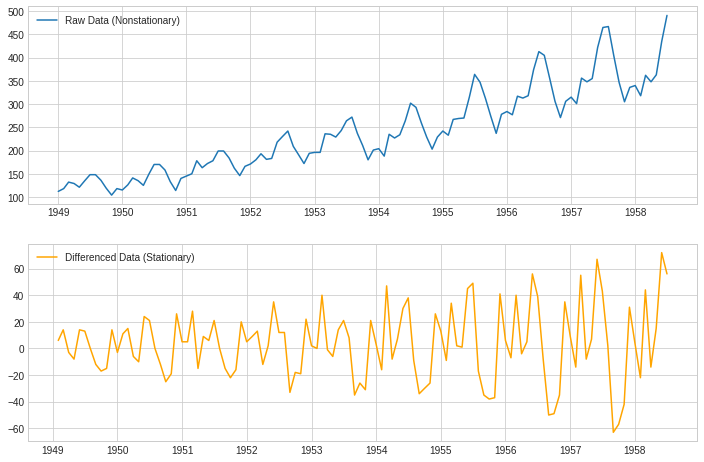

In [16]:
#plot
plt.figure(figsize=(12,8))
plt.subplot(211)  # 입력 값 = 행의수, 열의수, 앞의 수로 만든 행렬의 index
plt.plot(train_Airdata['passengers'])
plt.legend(["Raw Data (Nonstationary)"])
plt.subplot(212)
plt.plot(diff_train_Airdata, 'orange')  # difference (t - (t-1))
plt.legend(['Differenced Data (Stationary)'])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


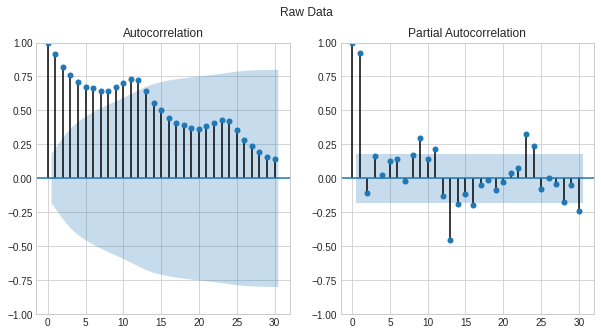

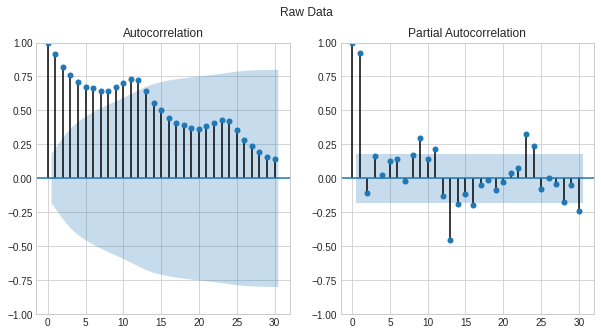

In [17]:
# autocorrelation function 과 partial autocorrelation function 상관관계
fig, ax = plt.subplots(1,2, figsize = (10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_Airdata.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_Airdata.values.squeeze(), lags=30, ax=ax[1])